 # Graphs algorithm
## Load the data

In [1]:
# Import necessary modules
import json,glob,random,time,re,networkx as nx
import matplotlib as mpl, matplotlib.pyplot as plt
from pythonds.basic.stack import Stack
from pythonds.basic import Queue
from itertools import combinations, product, filterfalse

d = {}
pattern = "C:/.../directory/*.json"  # with *.json we want to take all the files in json format
for files in glob.iglob(pattern):
    with open(files, "r") as f:
        data = json.load(f)
        d[data["query"][3:]] = data['results'][0]

''' Each query is in the form 'id:Axxxxxx', so with the slicing operation i want to extract only
the Axxxxxx part '''
        
# Define a funcion so that given a key it returns a list of all the references founded

def getref(key, d):
    lst = [] 
    if 'xref' in d.get(key): # check if the "xref" key is in the dict
        xr = d.get(key)['xref'] # list of strings 
        pattern = 'A'+'[0-9]'*6  # structure of the sequnces ID
        for string in xr:
            sequences = re.findall(pattern,string) # list of sequences
            lst.extend(sequences) 
    return lst

print("Number of sequences ", len(d))

Number of sequences  83217


## Construct the Graph: 
 - **According to Wikipedia my problem can be studied both on directed and undirected graph , so i choose to build a directed graph**

In [2]:
# create the graph by iterating on the keys of d   
def create_graph(d):
    G = nx.DiGraph()
    c = 0 
    for key in d:
        G.add_node(key)
        ref = getref(key,d) # obtain list of the references to other sequences
        if ref == []:
            c+=1
        else:
            G.add_edges_from([(key,nbr) for nbr in ref])
        d[key] = ref  
    nx.set_node_attributes(G,"white","visit")
    print("Vertices with no refs ", c) # number of vertices with no refs 
    return G

"""If we print the number of nodes we notice that there are 83221 nodes, but in our dataset
there are only 83217 json files. This maybe follow the fact that there are some sequences that
refers to others that are not in our dataset (in OEIS there are 341962 sequences!), 
and when we add an edge between 2 vertices, if the vertex is not in the dictionary, Python
automatically create it."""

G = create_graph(d)
print("Number of vertices ", G.number_of_nodes())
print("Number of edges ", G.number_of_edges())

Vertices with no refs  5237
Number of vertices  83221
Number of edges  483854


## Algorithm l: Find a Minimal Feedback Vertex Set

- what is a Feedback Vertex Set(FVS) --> https://en.wikipedia.org/wiki/Feedback_vertex_set

-  A set S satisfying a property P (e.g. being a dominating set) is minimal if does not exists an element x in S such that S - {x} still satisfies the property.

### Find a Feedback Vertex Set 

In [3]:
start = time.time()
print("is DAG? ", nx.is_directed_acyclic_graph(G)) # expected: FALSE
print("Total number of nodes in G is ", G.number_of_nodes())

def fvs(C,nlist):
    vset = set()
    for vertex in nlist:
        if C.nodes[vertex]["visit"] == 'white':
            vset.update(dfsCycle(C,vertex))
            
    return vset 

def dfsCycle(C,startvertex,v = set()):  # iterative version of DFS
    s = Stack()
    s.push(startvertex)
    while s.isEmpty() == False:
        currvert = s.peek()
        if C.nodes[currvert]["visit"] != "grey":
            C.nodes[currvert]["visit"] = "grey" 
            for node in set(C.successors(currvert)): 
                if C.nodes[node]["visit"] == "white":
                     C.nodes[node]["pred"] = currvert # currvert is the father of n
                     s.push(node)
                elif C.nodes[node]["visit"] == "grey":
                    v.add(node)
        else:
            s.pop()
            C.nodes[currvert]["visit"] = "black"
    return v


G_C = G.copy()
feed_vset = fvs(G, set(G.nodes))
end = time.time()
print("Length of the FVS is ", len(feed_vset))
print(f"Runtime of the program is {end - start}")


is DAG?  False
Total number of nodes in G is  83221
Length of the FVS is  43161
Runtime of the program is 11.404681205749512


### Find a Minimal Solution

In [4]:
"""In FVS there are more vertices than necessary for deleting cyclces in the graph. This is because
there are some vertices whose removal could delete more than one cycle; this fact is NOT captured
in my algorithm, which it's only able to delete at least one vertex for each cycle in the graph.
What i want to do here is find an MFVS (Minimal Feedback Vertex Set), i.e. a set in which
there isn't any element that could be removed and still have a FVS"""

def mfvs(C,H,fvs):
    
    min_fvs = fvs.copy() # create a copy of the FVS
    C.remove_nodes_from(fvs) # remove all the nodes in the FVS , so now the graph is acyclic. 
    # Now G is G\FVS
    print("After removing FVS, is DAG? ", nx.is_directed_acyclic_graph(C)) # expected: TRUE
    print("Number of nodes in the modified graph ", C.number_of_nodes())
    
    while len(fvs)!=0:
        vert = fvs.pop() # pick a random element from the FVS
        C.add_node(vert)
        if vert not in H.successors(vert): # if not a self loop
            parents = set(H.predecessors(vert)) - min_fvs
            sons = list(set(H.successors(vert)) - min_fvs) 
            C.add_edges_from([(node,vert) for node in parents])
            
            counter = 0 
            cyc = False
            while counter < len(sons) and not cyc:
                C.add_edge(vert, sons[counter])
                if nx.has_path(C, sons[counter], vert): 
                    C.remove_node(vert)
                    cyc = True
                counter += 1
            if not cyc or not any(sons) or not any(parents) :
                min_fvs.remove(vert)
        else: # is a self loop 
            C.remove_node(vert)
    return min_fvs

min_feed_vset = mfvs(G,G_C,feed_vset)
print("Length of the MFVS is ", len(min_feed_vset))
print("After removing MFVS, is still a DAG? ", nx.is_directed_acyclic_graph(G)) 


After removing FVS, is DAG?  True
Number of nodes in the modified graph  40060
Length of the MFVS is  36062
After removing MFVS, is still a DAG?  True


## Algorithm ll: Find **all** the Minimal Feedback Vertex Sets 
### Quasi-random graph 

In [5]:
random.seed(190397)

def dfs(C):
    nlist = []  
    nx.set_node_attributes(C,"white","visit") # set all the nodes as "univisited"
    for i in range(5): # start some dfs visit from different point 
        sbset = dfsvisit(C,random.choice(list(C.nodes)))
        nlist.extend(sbset)    
    return nlist
        
def subgraph(C):
    nodelist = dfs(C)
    par_sub = C.subgraph(nodelist).copy()
    # with subgraph nodes and edges are shared with the original graph 
    for node in nodelist: # ..add some leaf nodes
        sons = set(C.successors(node)) - set(nodelist)
        if any(sons):
            child = sons.pop()
            par_sub.add_edge(node, child)
        else:
            pass
    return par_sub
          
def dfsvisit(C,curr,subset = set(),c=1):

    if c == 15: # base case
        return subset
    
    C.nodes[curr]["visit"] = "grey"
    subset.add(curr)
    for node in set(C.successors(curr)):
        if C.nodes[node]["visit"] == "white":
            C.nodes[node]['pred'] = curr
            return dfsvisit(C,node,subset,c=c+1)    
    C.nodes[curr]["visit"] = "black"
    return dfsvisit(C,C.nodes[curr]['pred'],subset,c)

# Here when a node has no white neighbours, we run a DFS starting from the predecessor of the node.

    


sub = subgraph(G_C)
sscs= list(nx.strongly_connected_components(sub))
print("Number of nodes in the graph ",sub.number_of_nodes())
print("Number of ssc " ,len(sscs))


Number of nodes in the graph  114
Number of ssc  68


### Bruteforce algorithm on SCCs

In [6]:
start = time.time()
def all_mfvs(C):
    a_mfvs = {}
    count = 0
    scc = nx.strongly_connected_components(C) # it's a lazy generator
    for s in scc:   # for each scc
        count +=1
        record = []
        all_comb = gen_comb(s) # it's a set of tuples
        for comb in all_comb:
            comb = set(comb) # convert the tuple into a set
            scc_graph = C.subgraph(s).copy() # each time generate the ssc
            if is_mfvs(scc_graph,comb.copy()):
                record.append(comb)
        a_mfvs[count] = record
    clean = filterfalse(lambda x: x==[] ,a_mfvs.values())
    r = product(*map(lambda x: (x[i] for i in range(len(x))),clean))
    return (set().union(*i) for i in r)

    """
    DESCRIPTION: 
    With filterfalse function we eliminate void lists in the dictionary; it returns a generator
    With 'map' we apply the lambda expression to the iterable which in this case is a list of the 
    dictionary values.
    Lambda expression take an iterable in input and returns a generator in which each value is a mfvs
    for the corrisponding SCC
    Product function from itertools module require an iterable in Input, where * means that 
    the number of items passed to the function is a priori undefined; the function returns
    an iterator object (here "r"). The return value of all_mfvs it's a lazy generator, whose
    elemnts are MFVS
    """   
    
def gen_comb(scclist):
    comb = set()
    for l in range(1, len(scclist)+1):
        comb.update(set(combinations(scclist, l)))
    return comb

def is_mfvs(C,fvs):
    H = C.copy()  # it will be our ssc 
    fvs_copy = fvs.copy() # create a copy of the FVS
    C.remove_nodes_from(fvs) 
    if not nx.is_directed_acyclic_graph(C):
        return False
    while len(fvs)!=0:
        vert = fvs.pop() # pick one element from the FVS
        C.add_node(vert)
        if vert not in H.successors(vert): # is not a self loop
            parents = set(H.predecessors(vert)) - fvs_copy
            sons = list(set(H.successors(vert)) - fvs_copy)
            C.add_edges_from([(node,vert) for node in parents])
            counter = 0 
            cyc = False
            while counter < len(sons) and not cyc:
                C.add_edge(vert, sons[counter])
                if nx.has_path(C, sons[counter], vert): 
                    C.remove_node(vert)
                    cyc = True
                counter += 1
            if not cyc or not any(sons) or not any(parents) :
                return False
        else:
            C.remove_node(vert) # is a self loop so induce a loop 
    return True 

all_solutions = all_mfvs(sub)
end = time.time()
print(f"Runtime of the program is {end - start}")

Runtime of the program is 0.9333624839782715


### Graph Visualization

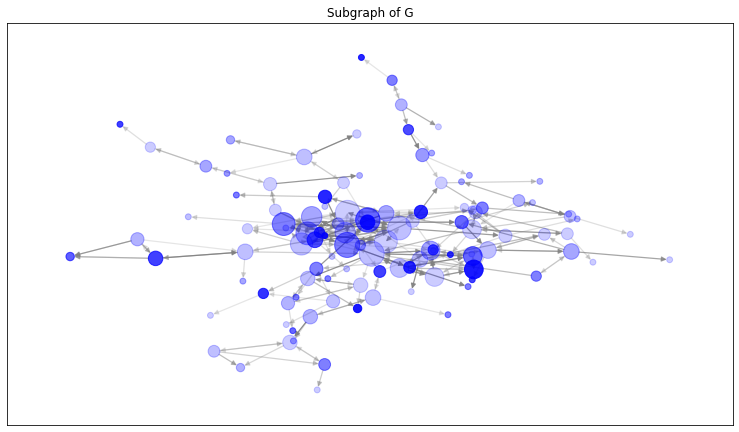

In [21]:
%matplotlib inline
fig = plt.figure(figsize= (13.0,7.4))
plt.title("Subgraph of G")
d = dict(sub.degree)
nx.draw_networkx(sub,pos=nx.kamada_kawai_layout(sub), node_size = [v * 35 for v in d.values()], with_labels= False,node_color = "blue", 
                 alpha =[v * 0.05 for v in d.values() if v > 3], edge_color = "grey", width = 1.25)
fig.savefig('matplotgraph.png')

## Algorithm III: Find a **minimum** solution

In [22]:

def minimum_fvs(C,all_sol):
    min_len = float("inf")
    minimum = None 
    tot = 0
    for solution in all_sol:
        tot +=1
        if len(solution) < min_len:
            min_len  = len(solution)
            minimum = solution
    print("Total number of solutions ", tot)
    return minimum    
  

min_solution = minimum_fvs(sub, all_solutions)
print("Size of minimum solution ", len(min_solution))
print("Minimum solution ", min_solution)    

Total number of solutions  1244160
Size of minimum solution  32
Minimum solution  {'A054743', 'A325238', 'A002981', 'A103317', 'A116532', 'A210761', 'A319616', 'A097792', 'A276086', 'A127102', 'A128396', 'A230955', 'A210758', 'A127100', 'A242153', 'A210760', 'A210759', 'A000142', 'A230953', 'A000410', 'A128397', 'A127104', 'A116539', 'A000612', 'A186986', 'A328119', 'A127106', 'A127101', 'A242027', 'A186974', 'A210757', 'A051674'}
